# 09: Let's put it all together – ruptures and their deformation models

This notebook provides a comprehensive workflow for analyzing earthquake rupture models and their associated surface deformation patterns. This is our first **capstone notebook**, where we are putting together all the pieces from what we've learned in class so far. The workflow is modeled after a real-world example from a peer-reviewed scientific paper, giving you hands-on experience with research-level data analysis.

The primary objectives are:

- **Reading and Visualizing Rupture Models:** Load rupture scenarios generated by earthquake simulations and visualize the spatial distribution of slip on the fault.
- **Deformation Modeling:** Read and plot the predicted surface deformation (vertical and horizontal displacements) resulting from each rupture scenario.
- **Comparison with Paleoseismic Data:** Compare the modeled deformation with paleoseismic observations (e.g., subsidence data from geological records) to assess how well each rupture scenario matches real-world evidence.
- **Quantitative Evaluation:** Calculate the root mean square (RMS) misfit between modeled and observed deformation at paleo sites to objectively measure the "goodness-of-fit" for each scenario.
- **Scenario Exploration:** Systematically explore a suite of rupture and deformation models, visualize them as a grid, and identify the best-fitting scenarios.
- **Selection of Best Candidates:** Highlight and further analyze the scenarios that best reproduce the observed paleoseismic data.

By following this workflow, users can evaluate the plausibility of different earthquake rupture models in the context of geological and geodetic constraints, ultimately improving our understanding of earthquake hazards in the Cascadia region.

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob

# Path to rupture model and deformation data
path = '/Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/ruptures/gamma/cascadia1700_gamma.000500.rupt'
deformation_path = '/Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/statics/cascadia1700_1cm.000500/statics.neu'

# Read rupture model data
rupt = np.genfromtxt(path)
print(rupt)

[[1.00000000e+00 2.31624971e+02 4.99814920e+01 ... 1.17813400e+04
  3.46900000e+02 2.86838600e+10]
 [2.00000000e+00 2.35587161e+02 4.03377380e+01 ... 1.30476100e+04
  5.35600000e+01 4.04320000e+10]
 [3.00000000e+00 2.35512371e+02 4.15786710e+01 ... 1.35620800e+04
  2.10800000e+01 4.04320000e+10]
 ...
 [1.39500000e+03 2.36232376e+02 4.19088940e+01 ... 1.46441100e+04
  3.81200000e+01 4.66322900e+10]
 [1.39600000e+03 2.36162422e+02 4.16800110e+01 ... 1.32665000e+04
  3.77400000e+01 4.66322900e+10]
 [1.39700000e+03 2.36229430e+02 4.17345760e+01 ... 1.35882300e+04
  3.89300000e+01 4.66322900e+10]]


Note we are now also using the `glob` module–– this is a standard Python library for finding files and directories whose names match a specified pattern. You haven't seen `glob` yet, but it's a very useful tool for working with large collections of files.

The main function, `glob.glob()`, searches for all the pathnames matching a given pattern according to the rules used by the Unix shell. For example, you can use wildcards like `*` to match any number of characters. This is especially helpful when you want to process many files with similar names (such as simulation outputs or data files) without having to list each one manually.

**Example usage:**

```python
from glob import glob

# Find all files ending with '.txt' in the current directory
txt_files = glob('*.txt')
print(txt_files)
```

This will print a list of all `.txt` files in the directory. In this notebook, `glob` is used to automatically find all the folders or files that match a certain pattern, making it easy to loop through and analyze large datasets.

### Ok back to our regualrly scheduled programming

Often, the first step after reading in a data file is to make a quick plot of the data. This isn't necessarily for analysis, but rather to visually inspect the dataset, check for obvious issues (like missing values, outliers, or formatting problems), and to get an initial sense of the structure and range of the data. This simple check can help catch problems early and guide the next steps in your workflow.

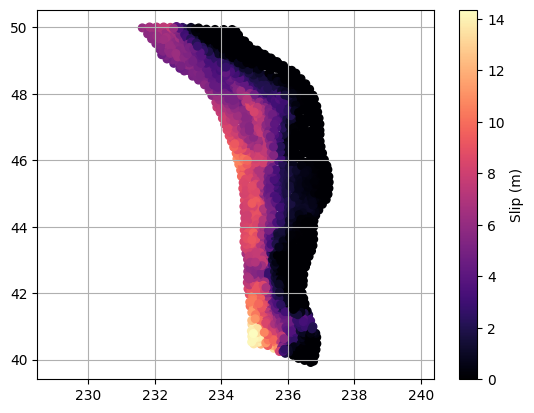

In [100]:
# Ok let's plot the "subfaults" as individual symbols
plt.scatter(rupt[:, 1], rupt[:, 2], c=rupt[:, 9], cmap='magma', s=30)
plt.colorbar(label='Slip (m)')
plt.axis('equal')
plt.grid(which='both')

In the previous steps, we visualized the rupture and deformation models using scatter plots and color maps to represent slip and displacement.

When creating visualizations, especially with color maps, it's important to consider the choice of colormap for clarity and accessibility. Two important concepts are:

- **Perceptually Uniform Colormaps:** These colormaps are designed so that equal steps in data are perceived as equal steps in color by the human eye. This means that the color changes smoothly and consistently across the entire range, making it easier to interpret gradients and compare values. Examples include `viridis`, `plasma`, and `cividis`. These are especially recommended for representing continuous data because they are also colorblind-friendly and print well in grayscale.

- **Diverging Colormaps:** These colormaps are useful when your data has a meaningful central value (such as zero) and you want to highlight deviations above and below this midpoint. Diverging colormaps (like `seismic`, `coolwarm`, or `bwr`) use contrasting colors at the ends and a neutral color in the center, making it easy to see positive and negative differences.

Some older colormaps, such as the famous `jet`, are now considered poor choices for scientific visualization. The `jet` colormap is not perceptually uniform: it changes hue rapidly and unevenly, which can introduce artificial visual boundaries and make it hard to interpret the data accurately. It can also be misleading for viewers with color vision deficiencies and does not translate well to grayscale.

You can explore available colormaps in Matplotlib's documentation:  
https://matplotlib.org/stable/users/explain/colors/colormaps.html

Experimenting with different colormaps can help make your figures more interpretable and visually appealing.

### Let's put some more things together

The goal of visualization at this stage is to bring together multiple aspects of the earthquake models—such as slip distribution and surface deformation—so we can look for patterns, correlations, or inconsistencies. By displaying these datasets side by side in a multipanel plot, we can more easily assess how the rupture characteristics relate to the predicted deformation, and whether any systematic trends or outliers emerge. This approach helps us quickly identify which scenarios are plausible and which are not, guiding further analysis and interpretation.

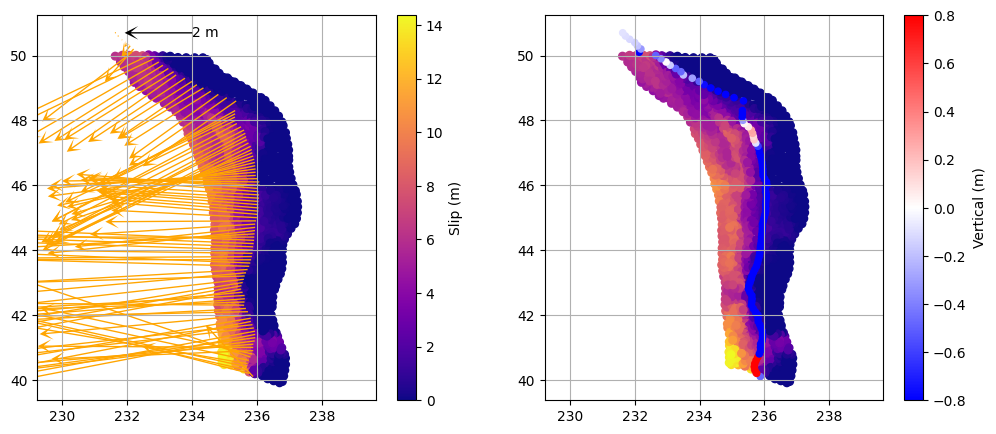

In [101]:
# Plot the rupture slip and associated deformation vectors and vertical displacement

# Read deformation data for the current scenario
deformation = np.genfromtxt(deformation_path)

# Decimate deformation points for clarity in the plot
deformation = deformation[::10, :]

plt.figure(figsize=(12, 5))

# --- Left subplot: Rupture slip and deformation vectors ---
plt.subplot(121)

# Plot rupture slip as colored scatter
plt.scatter(rupt[:, 1], rupt[:, 2], c=rupt[:, 9], cmap='plasma', s=30)
plt.colorbar(label='Slip (m)')
plt.axis('equal')
plt.grid(which='both')

# Add a horizontal scale arrow at lat=50.7, lon=234 (2 m length)
plt.quiver(234, 50.7, -2, 0, color='k', scale=10, width=0.004, headlength=10, headwidth=10, zorder=10)
plt.text(234, 50.7, '2 m', color='k', va='center', fontsize=10)

# Plot deformation vectors (horizontal: col 4, vertical: col 3)
plt.quiver(
    deformation[:, 1], deformation[:, 2],  # X (lon), Y (lat)
    deformation[:, 4], deformation[:, 3],  # U (east), V (north)
    color='orange', scale=10, width=0.004, headlength=10, headwidth=10
)

# --- Right subplot: Rupture slip and vertical deformation ---
plt.subplot(122)

# Plot rupture slip as background
plt.scatter(rupt[:, 1], rupt[:, 2], c=rupt[:, 9], cmap='plasma', s=30)
plt.axis('equal')
plt.grid(which='both')

# Plot vertical displacement as colored scatter
plt.scatter(
    deformation[:, 1], deformation[:, 2],
    c=deformation[:, 5], cmap='bwr', s=20, vmin=-0.8, vmax=0.8
)
plt.colorbar(label='Vertical (m)')




### What about the paleoseismic data???

Now that we have visualized the rupture and deformation models, the next step is to bring in paleoseismic data—real geological observations of past earthquake-induced subsidence. By comparing these "ground truth" measurements with the predictions from our deformation models, we can assess how well each scenario matches the actual geological record. This comparison is crucial for evaluating the plausibility of different rupture models and understanding which ones best reproduce the observed patterns of vertical displacement along the margin.

Text(0.5, 1.0, 'Modeled Deformation vs. Paleo Data')

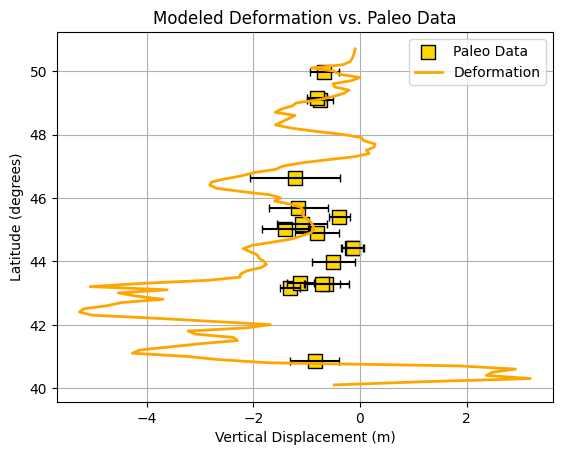

In [102]:
# Load paleoseismic data (latitude, longitude, observed subsidence, error)
paleo = np.genfromtxt('/Users/dmelgarm/Cascadia1700/paleo/paleo_data.txt')

# Prepare deformation data for plotting (sort by latitude for a smooth line)
z = deformation[:, 5]      # Vertical displacement
lat = deformation[:, 2]    # Latitude
i = np.argsort(lat)
lat = lat[i]
z = z[i]

plt.figure()
# Plot paleo data with error bars (horizontal error = paleo[:,3])
plt.errorbar(
    paleo[:, 2], paleo[:, 0], xerr=paleo[:, 3],
    fmt='none', ecolor='k', capsize=3
)
# Plot paleo data points
plt.scatter(
    paleo[:, 2], paleo[:, 0],
    marker='s', facecolor='gold', edgecolor='k', s=100, label='Paleo Data'
)
# Plot modeled deformation profile
plt.plot(z, lat, color='orange', lw=2, label='Deformation')
plt.grid(which='both')
plt.xlabel('Vertical Displacement (m)')
plt.ylabel('Latitude (degrees)')
plt.legend()
plt.title('Modeled Deformation vs. Paleo Data')



### What is "good" and "bad"?

Do you think this model is "good" or "bad"? How could we objectively quantify how well the model matches the paleoseismic data? 

One common approach is to use the **Root Mean Square (RMS) error** as a measure of misfit between the modeled and observed values. The RMS error is defined as:

$$
\mathrm{RMS} = \sqrt{ \frac{1}{N} \sum_{i=1}^N \left( z^{\text{model}}_i - z^{\text{obs}}_i \right)^2 }
$$

where $z^{\text{model}}_i$ is the modeled deformation at site $i$, $z^{\text{obs}}_i$ is the observed value, and $N$ is the number of paleo sites.

Using RMS is helpful because it provides a single number that summarizes the overall difference between the model and the data—lower RMS values indicate a better fit. This allows us to systematically compare different models and identify which ones best reproduce the observed deformation.

### Comapring apples to oranges

Another challenge is that the deformation predicted by the model is not computed at the exact same locations as the paleoseismic sites. To compare the two, we need to estimate the modeled deformation at the paleo site locations. This is where **interpolation** comes in.

**Interpolation** is a mathematical method for estimating unknown values that fall between known data points. In this context, we use interpolation to estimate the model's predicted deformation at the precise latitudes of the paleo sites, based on the surrounding model grid points.

There are many types of interpolation, each with its own assumptions and trade-offs:

- **Linear interpolation** connects the nearest data points with straight lines. It's simple and often sufficient when the data varies smoothly.
- **Spline interpolation** fits smooth curves through the data, which can better capture gradual changes but may introduce artifacts if the data is noisy or irregular.
- **Nearest-neighbor interpolation** simply assigns the value of the closest known point, which can be useful for categorical data but may be too rough for continuous variables.

The choice of interpolation method depends on the nature of your data and the level of smoothness or accuracy you need. For most geophysical applications with smoothly varying fields, linear or spline interpolation are common choices. In this notebook, we use linear interpolation for its simplicity and reliability.

In [103]:
# Re-read the deformation data for the current scenario (no interpolation yet)
deformation = np.genfromtxt(deformation_path)

# Extract vertical displacement (z) and latitude (lat) from deformation data
z = deformation[:, 5]      # Vertical displacement (meters)
lat = deformation[:, 2]    # Latitude (degrees)

# Sort by latitude for consistent interpolation
i = np.argsort(lat)
lat = lat[i]
z = z[i]

# Create a linear interpolator for vertical displacement as a function of latitude
interp = interp1d(lat, z, kind='linear', bounds_error=False, fill_value='extrapolate')

# Interpolate modeled vertical displacement at the paleo site latitudes
paleo_z = interp(paleo[:, 0])

# Calculate the RMS error between modeled and observed paleo subsidence
rms = np.sqrt(np.mean((paleo_z - paleo[:, 2])**2))
print(f'RMS error: {rms:.3f} m')


RMS error: 1.806 m


Is the RMS value you calculated "good" or "bad"? How do you decide what is an acceptable level of misfit between the model and the paleoseismic data? This is a fundamental challenge in model evaluation: setting a threshold for what counts as a "good" fit.

One reasonable approach is to look at the uncertainties in the paleoseismic data themselves. If the model's RMS error is smaller than or comparable to the typical uncertainty in the observations, then the model is performing about as well as the data allow. A practical threshold for a "good" model might be the average uncertainty of the paleoseismic measurements (i.e., the mean of the error bars in the paleo dataset).

---

#### About `interp1d` and its arguments

The `interp1d` function from `scipy.interpolate` is used to estimate model values at the exact latitudes of the paleo sites. Here’s what each argument means in this context:

- `lat`: The sorted array of latitudes from the model output (must be monotonically increasing for interpolation).
- `z`: The corresponding vertical displacement values at each latitude.
- `kind='linear'`: Specifies linear interpolation, which is appropriate for smoothly varying geophysical data.
- `bounds_error=False`: Allows extrapolation outside the range of the input data, rather than raising an error.
- `fill_value='extrapolate'`: Ensures that if a paleo site falls outside the model latitude range, the function will still return a value using linear extrapolation.

This setup ensures that every paleo site receives a modeled value, even if it falls slightly outside the model grid, and that the interpolation is simple and robust for this type of data.

Let's make the plot a little prettier by improving the layout, adding clearer labels, and using color schemes that enhance readability. Small adjustments to font sizes, legend placement, and axis formatting can make your figures more publication-ready and easier to interpret.

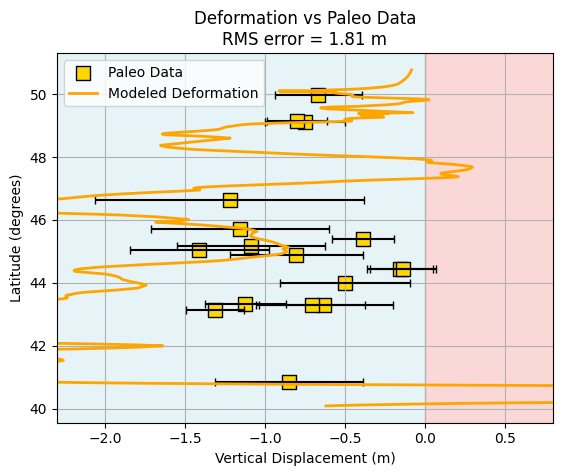

In [104]:

# Plot modeled deformation vs. paleo data with improved layout and comments

plt.figure()

# Plot paleo data with error bars (horizontal error = paleo[:,3])
plt.errorbar(
    paleo[:, 2], paleo[:, 0], xerr=paleo[:, 3],
    fmt='none', ecolor='k', capsize=3
)

# Plot paleo data points
plt.scatter(
    paleo[:, 2], paleo[:, 0],
    marker='s', facecolor='gold', edgecolor='k', s=100, label='Paleo Data'
)

# Plot modeled deformation profile
plt.plot(z, lat, color='orange', lw=2, label='Modeled Deformation')

# Highlight regions of uplift and subsidence
plt.axvspan(-2.5, 0, color='lightblue', alpha=0.3, zorder=0)   # Subsidence
plt.axvspan(0, 1, color='lightcoral', alpha=0.3, zorder=0)     # Uplift

plt.grid(which='both')
plt.xlim(-2.3, 0.8)
plt.xlabel('Vertical Displacement (m)')
plt.ylabel('Latitude (degrees)')
plt.title(f'Deformation vs Paleo Data\nRMS error = {rms:.2f} m')
plt.legend()

(39.5, 50.5)

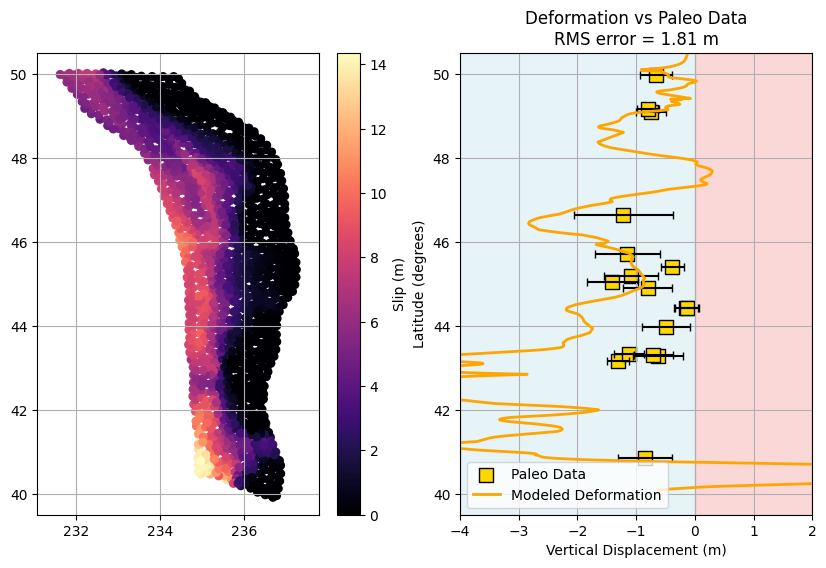

In [105]:
#now plot the slip model and the deformation together in a single almost publication quality plot!
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.scatter(rupt[:, 1], rupt[:, 2], c=rupt[:, 9], cmap='magma', s=30)
plt.colorbar(label='Slip (m)')
plt.axis('equal')
plt.grid(which='both')
plt.ylim(39.5, 50.5)

plt.subplot(122)
plt.errorbar(paleo[:,2], paleo[:,0], xerr=paleo[:,3], fmt='none', ecolor='k', capsize=3)
plt.scatter(paleo[:,2], paleo[:,0], marker='s', facecolor='gold', edgecolor='k', s=100, label='Paleo Data')
plt.plot(z, lat, color='orange', lw=2, label='Modeled Deformation')
plt.grid(which='both')
plt.title(f'Deformation vs Paleo Data\nRMS error = {rms:.2f} m')
plt.axvspan(-4, 0, color='lightblue', alpha=0.3, zorder=0)
plt.axvspan(0, 2, color='lightcoral', alpha=0.3, zorder=0)
plt.xlim(-4,2)
plt.xlabel('Vertical Displacement (m)')
plt.ylabel('Latitude (degrees)')
plt.legend()
plt.ylim(39.5, 50.5)


### A Challenge: Are any of the modeled ruptures any good???

Go back and manually change the file paths in the relevant code cells to load and plot different rupture scenarios. Use the RMS error as a guide—try to find a rupture model with a low RMS value (as discussed above) that best matches the paleoseismic data. Once you identify a "good" candidate, plot its deformation profile alongside the paleo data for comparison.

### Can we view everything together?

Randomly trying different rupture scenarios is inefficient. Could we maybe visualize all of the deformations together to get a better overview of the entire model suite?

To do this, we will read in all the deformation profiles from each scenario and store them in a single array. This allows us to visualize the entire collection of models at once using a new plotting concept called `pcolormesh`. With `pcolormesh`, we can display the vertical displacement from every scenario as a color-coded grid, making it easy to spot patterns, outliers, or promising candidates across the whole suite of models.

In [106]:
# Set the path to the directory containing all deformation model folders
models_path = '/Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/statics/'

# Find all folders matching the 'gamma' scenario pattern and sort them
all_folders = glob(models_path + '*gamma*')
all_folders.sort()

# Number of deformation points and scenarios (already defined)
N_deformation_points = 1048
N_scenarios = 1000

# Pre-allocate array to store all deformation profiles
all_deformations = np.zeros((N_deformation_points, N_scenarios))

# Loop over each scenario folder and read the deformation data
for k in range(len(all_folders)):
    folder = all_folders[k]
    # Build the path to the deformation file for this scenario
    file_path = folder + '/statics.neu'
    data = np.genfromtxt(file_path)

    # Extract vertical displacement (z) and latitude (lat)
    z = data[:, 5]
    lat = data[:, 2]

    # Sort by latitude for consistency across scenarios
    i = np.argsort(lat)
    lat = lat[i]
    z = z[i]

    # Store the sorted vertical displacement profile in the array
    all_deformations[:, k] = z


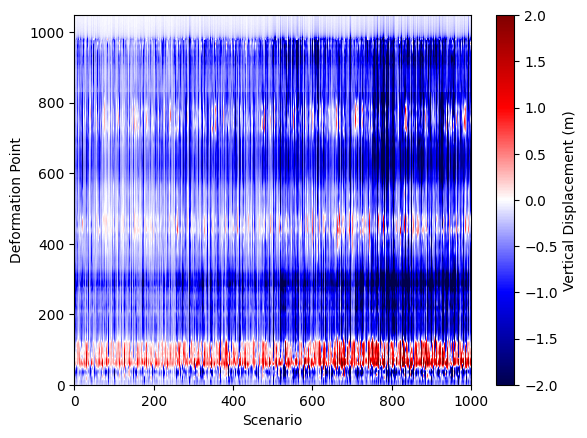

In [107]:
# a quick and dirty view

plt.figure()
plt.pcolormesh(all_deformations, cmap='seismic', vmin=-2, vmax=2)
plt.xlabel('Scenario')
plt.ylabel('Deformation Point')
plt.colorbar(label='Vertical Displacement (m)')

### What just happened?

In the previous steps, we loaded all the deformation profiles from every rupture scenario into a single large array called `all_deformations`. Each column in this array represents the vertical displacement profile for one scenario, sorted by latitude. We then visualized this collection using a `pcolormesh` plot, which displays the vertical displacement for all scenarios as a color-coded grid. This approach allows us to quickly compare the full suite of models, spot patterns, and identify which scenarios might best match the paleoseismic data. By stacking all the results together, we gain a comprehensive overview of the variability and trends across the entire model ensemble.

While this visualization is powerful for seeing the diversity of deformation patterns, it doesn't give us an intuitive sense of which one of these "strips" (scenarios) is actually a good or bad fit to the paleoseismic data. Ideally, we'd like to visualize the RMS misfit for each scenario directly on the figure, so we can immediately see which models are performing well and which are not.

In [108]:
# Calculate the RMS misfit for ALL scenarios and save the results in a numpy array

# Pre-allocate array to store RMS values for each scenario
rms_all_ruptures = np.zeros(N_scenarios)

# Loop over all scenario folders
for k in range(len(all_folders)):
    folder = all_folders[k]
    file_path = folder + '/statics.neu'
    data = np.genfromtxt(file_path)

    # Sort deformation data by latitude for consistent interpolation
    z = data[:, 5]      # Vertical displacement
    lat = data[:, 2]    # Latitude
    i = np.argsort(lat)
    lat = lat[i]
    z = z[i]

    # Interpolate modeled deformation at paleo site latitudes
    interp = interp1d(lat, z, kind='linear', bounds_error=False, fill_value='extrapolate')
    paleo_z = interp(paleo[:, 0])

    # Calculate RMS error between modeled and observed paleo subsidence
    rms = np.sqrt(np.mean((paleo_z - paleo[:, 2])**2))
    rms_all_ruptures[k] = rms  # Store RMS for this scenario


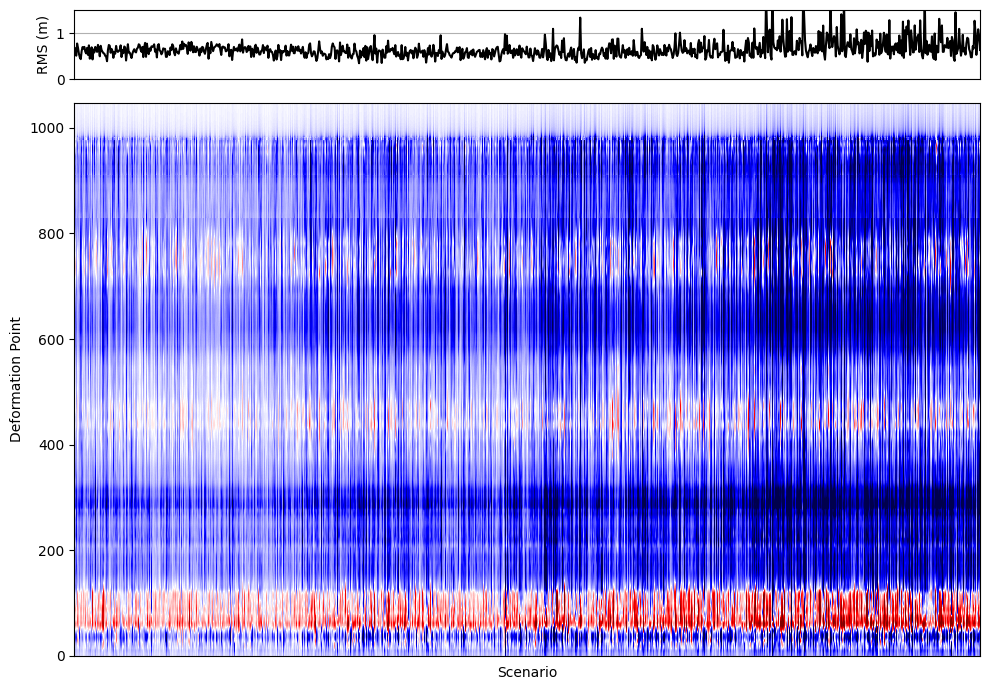

In [109]:
# Create a figure with two vertically stacked subplots (RMS line plot and deformation heatmap)
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7),
    gridspec_kw={'height_ratios': [1, 8]}, sharex=True
)

# --- Top axis: Plot RMS error for each scenario ---
ax[0].plot(rms_all_ruptures, color='k')
ax[0].set_ylabel('RMS (m)')
ax[0].set_xlim(0, N_scenarios-1)
ax[0].set_ylim(0, 1.5)
ax[0].grid(True)
ax[0].set_xticks([])  # Hide x-ticks for the top plot

# --- Bottom axis: Show deformation profiles for all scenarios as a heatmap ---
c = ax[1].pcolormesh(all_deformations, cmap='seismic', vmin=-2, vmax=2)
ax[1].set_xlabel('Scenario')
ax[1].set_ylabel('Deformation Point')
# Optionally add a colorbar for the heatmap:
# fig.colorbar(c, ax=ax[1], label='Vertical Displacement (m)')

plt.tight_layout()
plt.show()

In the previous visualization, we combined two key pieces of information for all rupture scenarios:

- **Top panel:** The RMS misfit for each scenario, showing how well each modeled deformation profile matches the paleoseismic data. Lower RMS values indicate a better fit.
- **Bottom panel:** A heatmap (`pcolormesh`) displaying the vertical displacement profiles for all scenarios, with each column representing a different rupture model.

This approach allows us to quickly identify which scenarios produce deformation patterns that are most consistent with geological observations. By visually linking the RMS error to the deformation profiles, we can efficiently screen hundreds or thousands of models, spot trends, and focus our attention on the most promising candidates for further analysis. This is especially valuable when dealing with large model ensembles, as it streamlines the process of model selection and interpretation.

In the next notebook, we will expand on these concepts to systematically identify both the best-fitting and worst-fitting rupture scenarios from the entire model suite. This will allow us to explore not only which models best match the paleoseismic data, but also to understand the range of possible ruptures and their implications for earthquake hazard assessment.